In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

sys.path.append(os.path.abspath(os.path.join('..')))
from src.sir_model import AgentBasedSIR
from src.rl_agent import QLearningAgent

In [2]:
N = 5000
BETA = 0.2
GAMMA = 1/7
C = 8
EPISODES = 500
MAX_STEPS = 150
ACTIONS = [0.0, 0.25, 0.50, 0.75, 1.0]

In [3]:
env = AgentBasedSIR(N=N, beta=BETA, gamma=GAMMA, C=C)
agent = QLearningAgent(action_space=ACTIONS, alpha=0.1, gamma=0.99, epsilon=0.5)

returns = []
moving_avg_returns = []

print("Starting RL Training...")
for episode in range(EPISODES):
    obs, _ = env.reset()
    state_key = agent.get_state_key((obs, 0), 0)
    total_reward = 0
    
    for t in range(MAX_STEPS):
        action_idx = agent.get_action(state_key)
        u_t = ACTIONS[action_idx]
        
        next_obs, new_infections = env.step(intervention_strength=u_t)
        
        # Reward Function
        cost = (1.0 * new_infections) + (15.0 * (u_t**2))
        reward = -cost
        total_reward += reward
        
        next_state_key = agent.get_state_key((next_obs, 0), t+1)
        agent.update(state_key, action_idx, reward, next_state_key)
        state_key = next_state_key
        
        if next_obs[1] == 0: break # I=0
            
    agent.decay_epsilon()
    returns.append(total_reward)
    avg = np.mean(returns[-20:]) if len(returns) >= 20 else np.mean(returns)
    moving_avg_returns.append(avg)
    
    if episode % 100 == 0:
        print(f"Episode {episode}: Avg Return = {avg:.2f}")

Starting RL Training...
Episode 0: Avg Return = -5349.56
Episode 100: Avg Return = -4873.91
Episode 200: Avg Return = -4117.84
Episode 300: Avg Return = -3235.32
Episode 400: Avg Return = -3063.17


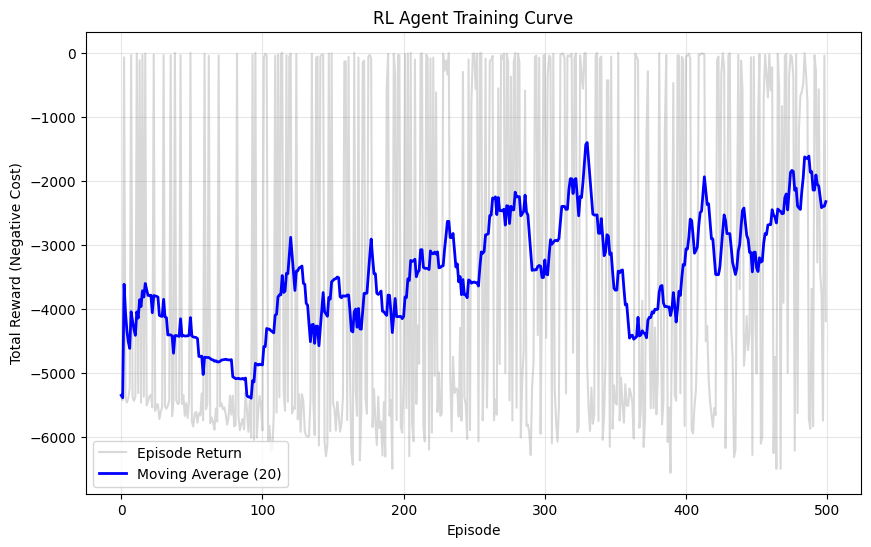

Plot saved to plots/03_rl_training.png


In [4]:
plt.figure(figsize=(10, 6))
plt.plot(returns, alpha=0.3, color='gray', label='Episode Return')
plt.plot(moving_avg_returns, color='blue', linewidth=2, label='Moving Average (20)')
plt.xlabel('Episode')
plt.ylabel('Total Reward (Negative Cost)')
plt.title('RL Agent Training Curve')
plt.legend()
plt.grid(True, alpha=0.3)

plt.savefig('../plots/03_rl_training.png', dpi=300)
plt.show()
print("Plot saved to plots/03_rl_training.png")

In [5]:
print("\n--- FINAL EVALUATION ---")
# 1. Baseline
env.reset()
baseline_infections = 0
for _ in range(MAX_STEPS):
    _, new_inf = env.step(intervention_strength=0.0)
    baseline_infections += new_inf
print(f"Baseline (No Intervention) Total Infections: {baseline_infections}/{N}")

# 2. Trained Agent
obs, _ = env.reset()
agent_infections = 0
state_key = agent.get_state_key((obs, 0), 0)
intervention_history = []

for t in range(MAX_STEPS):
    # Exploitation only (argmax)
    action_idx = np.argmax(agent.q_table.get(state_key, np.zeros(len(ACTIONS))))
    u_t = ACTIONS[action_idx]
    intervention_history.append(u_t)
    
    next_obs, new_inf = env.step(intervention_strength=u_t)
    agent_infections += new_inf
    state_key = agent.get_state_key((next_obs, 0), t+1)
    if next_obs[1] == 0: break

print(f"Trained Agent Total Infections: {agent_infections}/{N}")
print(f"Reduction: {100 * (baseline_infections - agent_infections)/baseline_infections:.1f}%")


--- FINAL EVALUATION ---
Baseline (No Intervention) Total Infections: 4999/5000
Trained Agent Total Infections: 1553/5000
Reduction: 68.9%
